デバッグ用（インストールしている場合は不要）

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../applicability_domain'))

### モジュールのインポート

In [2]:
from applicability_domain import ApplicabilityDomain

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

### 定数の定義

In [3]:
SEED = 334

### サンプルデータの取得，整形

In [4]:
boston = load_boston()
X = pd.DataFrame(boston['data'], columns = boston['feature_names'])
y = pd.Series(boston['target'], name = 'PRICE')

### trainデータとtestデータに分割

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

### ADインスタンスの生成

In [6]:
AD = ApplicabilityDomain(k = 5, alpha = 0.9)

### ADの内部かどうかの判定

In [7]:
boolean_train, boolean_test = AD.is_inside(X_train, X_test)

## 性能比較

In [8]:
rf = RandomForestRegressor(random_state = SEED, n_jobs = -1, n_estimators = 100)
rf.fit(X_train, y_train)
y_pred_on_train = rf.predict(X_train)
y_pred_on_test = rf.predict(X_test)

### MSE

スコアを表示するための関数を定義

In [9]:
class score:
    def __init__(self, y_true, y_pred, name = ''):
        self.name = name
        self.y_true = y_true
        self.y_pred = y_pred
        self.score = mse(self.y_true, self.y_pred)
        print('MSE({0}): {1:.3f}'.format(self.name, self.score))

訓練データのMSE

In [10]:
train_score = score(y_train, y_pred_on_train, name = 'train')

MSE(train): 1.775


テストデータのMSE

In [11]:
test_score = score(y_test, y_pred_on_test, name = 'test')

MSE(test): 11.386


訓練データのうちADの中にあるものに対するMSE

In [12]:
train_ad_score = score(y_train[boolean_train], y_pred_on_train[boolean_train], name = 'train_ad')

MSE(train_ad): 1.461


テストデータのうちADの中にあるものに対するMSE

In [13]:
test_ad_score = score(y_test[boolean_test], y_pred_on_test[boolean_test], name = 'test_ad')

MSE(test_ad): 6.289


### 結果を図示

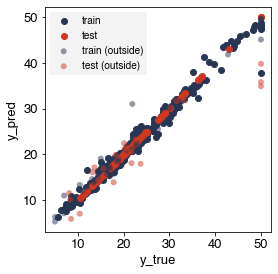

In [14]:
rcParams['font.size'] = 13
rcParams['font.family'] = 'Helvetica'

fig = plt.figure(facecolor = 'white')
ax = fig.add_subplot(111)

ax.scatter(train_ad_score.y_true, train_ad_score.y_pred, label = 'train', c = '#283655')
ax.scatter(test_ad_score.y_true, test_ad_score.y_true, label = 'test', c = '#cf3721')

ax.scatter(y_train[~boolean_train], y_pred_on_train[~boolean_train], label = 'train (outside)', c = '#283655', alpha = 0.5, edgecolor = 'None')
ax.scatter(y_test[~boolean_test], y_pred_on_test[~boolean_test], label = 'test (outside)', c = '#cf3721', alpha = 0.5, edgecolor = 'None')

ax.set_xlabel('y_true')
ax.set_ylabel('y_pred')

ax.set_aspect('equal')

ax.legend(facecolor = '#f0f0f0', edgecolor = 'None', fontsize = 10)

plt.tight_layout()

In [15]:
fig.savefig('example.png', dpi = 200)
plt.close()

### 'どれくらい遠いのか'の値を計算することができる

In [16]:
rd_train, rd_test = AD.get_ratio_distance(X_train, X_test)

きちんと同じ意味をなしていることが確認できる．

In [17]:
np.all((rd_train <= 1) == boolean_train)

True

In [18]:
np.all((rd_test <= 1) == boolean_test)

True

mseとratio distanceの相関

In [19]:
def each_mse(y_true, y_pred):
    y_diff = np.square(y_true - y_pred)
    return y_diff

In [20]:
y_diff_train = each_mse(y_train, y_pred_on_train)
y_diff_test = each_mse(y_test, y_pred_on_test)

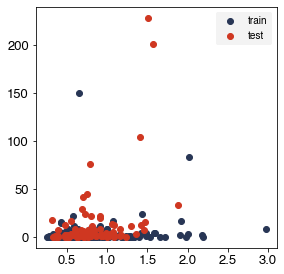

In [21]:
rcParams['font.size'] = 13
rcParams['font.family'] = 'Helvetica'

fig = plt.figure(facecolor = 'white')
ax = fig.add_subplot(111)

ax.scatter(rd_train, y_diff_train, label = 'train', c = '#283655')
ax.scatter(rd_test, y_diff_test, label = 'test', c = '#cf3721')

ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

ax.legend(facecolor = '#f0f0f0', edgecolor = 'None', fontsize = 10)

plt.tight_layout()